In [ ]:
# Créer un script qui fait tourner le modèle et l'enregistre

# Créer une fonction qui réduit l'image du papillon à partir du sample

# Voir à suppr les photo pieridea sur fond gris si < 20

# Modèle tester avec que les classes bien représentées
# Modèle avec balance 30 et que les espèce > 30
# Idem > 10
# Modèle avec data val que pour ces espèces

# Get data

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Sequential

2021-08-26 15:55:28.974842: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64
2021-08-26 15:55:28.974866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Fonctions

In [2]:
def image_resizing(img,size=None):
    '''Function that resize a picture. Size is a tuple of 2 integers : (lenght,width).'''
    img = img.resize(size)
    return img

def cat_encoder (y_train,y_val=None,y_test=None):
    '''This function return encoded targets : (y_train_cat,y_val_cat,y_test_cat).'''
    #----------- adding a second dimension to the target in order to proceed to the ohe ---------
    y_train = y_train.reshape(y_train.shape[0],1)
    y_val = y_val.reshape(y_val.shape[0],1)
    y_test = y_test.reshape(y_test.shape[0],1)
    #--------------------------------------- OneHotEncoding ---------------------------------
    ohe = OneHotEncoder(handle_unknown = "ignore",sparse=False)
    ohe.fit(y_train)
    result = []
    y_train_cat = ohe.transform(y_train)
    result.append(y_train_cat)
    if y_val is not None :
        y_val_cat = ohe.transform(y_val)
        result.append(y_val_cat)
    if y_test is not None:
        y_test_cat = ohe.transform(y_test)
        result.append(y_test_cat)
    return tuple(result)

def feature_engineering(df):
    '''That function add a species columns thanks to the genus and epithet columns'''
    df["path_to_image"]="../raw_data/IMG/"+df["image_name"]
    df['species'] = df['genus']+'_'+df['specific_epithet'] 
    return df

def set_nontrainable_layers(imported_model):
    '''set imported model layers' as non trainable'''
    imported_model.trainable = False
    return imported_model

def get_X_y(df,sample_size):
    '''This function return the features and target from a dataset'''
    data_sample = df.sample(sample_size, random_state = 818)
    image = []
    for i in data_sample['path_to_image'] :
        img = Image.open(i)
        #img = image_resizing(img)
        image.append(np.array(img))
    X = np.array(image)
    y = np.array(data_sample['species'])
    #careful, the feature X here is not resized and the target need to be reshaped before the onehotencoder
    return X, y

def get_data (data=["train","val","test"]):
    '''Function to get Train, Val and Test data. That function get in input a list of
    the desired data and return a tuple containing the 3 datasets : 
    (data_train,data_val,data_test)'''

    data_train = pd.read_json('../raw_data/splits/train.json').T
    data_val = pd.read_json('../raw_data/splits/val.json').T
    data_test = pd.read_json('../raw_data/splits/test.json').T

    data_dict = {"train":data_train,"val":data_val,"test":data_test}

    result = []
    for i in data :
        result.append(data_dict[i])
    return tuple(result)

def get_updated_model(imported_model,target):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional 
    trainable layers'''
    
    n_classes = pd.Series(target).nunique()
    imported_model = set_nontrainable_layers(imported_model)

    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(130, activation='relu')
    prediction_layer = layers.Dense(n_classes, activation='softmax')

    model = Sequential([imported_model,flattening_layer,dense_layer,prediction_layer])
    return model

def model_compile(model,learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
    adam = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=False,
    name='Adam', **kwargs)
    model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
    return model

## Code

In [80]:
data_train,data_val,data_test = get_data (data=["train","val","test"])
data_train=feature_engineering(data_train)
data_val=feature_engineering(data_val)
data_test=feature_engineering(data_test)
X_train,y_train = get_X_y(data_train,sample_size=1000)
X_val,y_val = get_X_y(data_val,sample_size=200)
X_test,y_test = get_X_y(data_test,sample_size=200)
y_train_cat,y_val_cat,y_test_cat = cat_encoder (y_train,y_val,y_test)

# Analyse du data_sample 

## Check n_unique() de species

### Data_train

In [15]:
print(pd.Series(y_train).nunique())
y_t_un = pd.Series(y_train).unique()

248


### Data_val

In [16]:
print(pd.Series(y_val).nunique())
y_v_un = pd.Series(y_val).unique()

131


### Data_test

In [17]:
print(pd.Series(y_test).nunique())
y_test_un = pd.Series(y_test).unique()

137


### Conclusion

**Combien y a-t-il d'spèce dans data_val qu'il n'y a pas dans le data_train ?**

In [18]:
count = 0
for i in y_v_un:
    if i not in y_t_un:
        count +=1
count

30

In [19]:
30/131

0.22900763358778625

**Combien y a-t-il d'espèce dans data_test qu'il n'y a pas dans le data_train ?**

In [20]:
count = 0
for i in y_test_un:
    if i not in y_t_un:
        count +=1
count

28

In [21]:
28/137

0.20437956204379562

## Check la balance des species

### Vérifier la balance

### Data_train

In [26]:
data_train.species.value_counts().head(10)

Parnassius_apollo     1414
Pieris_napi            633
Polyommatus_icarus     610
Plebejus_idas          573
Melitaea_athalia       519
Lysandra_coridon       459
Melitaea_didyma        439
Pieris_rapae           431
Cyaniris_semiargus     419
Lysandra_bellargus     396
Name: species, dtype: int64

In [27]:
pd.Series(y_train).value_counts().head(10)

Parnassius_apollo       35
Pieris_napi             25
Cyaniris_semiargus      17
Melitaea_didyma         16
Polyommatus_icarus      16
Pieris_rapae            16
Parnassius_mnemosyne    14
Erebia_euryale          14
Lycaena_tityrus         14
Plebejus_idas           12
dtype: int64

### Data_val

In [ ]:
pd.Series(y_val).value_counts()

### Data_test

In [ ]:
pd.Series(y_test).value_counts()

### Conclusion

**Le data_sample n'était pas balance sur le train**

# Data_set clean et balance

## Exploration

In [ ]:
# Prendre 20 sample pour les espèce > 20 images
# Regarder la taille du data_set
# Garder les mêmes espèces pour le data_val et data_test = sample 300 while espèce in y_train

In [ ]:
data_train.columns

### Récupère un df de 20 images par espèces

In [ ]:
data_tr_clean = data_train.loc[:,['species','path_to_image']]
data_tr_clean

In [ ]:
tri_species = data_tr_clean['species'].value_counts().reset_index()
tri_species.columns = ['species','nombre']
tri_species

In [ ]:
# Enregistre les espèces à garder
tri_species['nombre'] = tri_species['nombre'].astype('uint16')
keep_species = tri_species[tri_species['nombre']>19]['species']
keep_species = np.array(keep_species)
keep_species.shape

In [ ]:
# Créer une colonne pour filter
data_tr_clean['triage'] = [ i in keep_species for i in data_tr_clean['species']]
# Récupère le DF en filtrant sur les espèces de plus de 20 photos
data_cleaned20 = data_tr_clean.loc[data_tr_clean['triage'] == True, ['species', 'path_to_image']]

In [ ]:
data_cleaned20.species.nunique()

In [ ]:
data_cleaned20['triage']=[False for i in data_cleaned20['species']]

In [ ]:
data_cleaned20.drop('triage', axis = 1, inplace = True)

In [4]:
def get_data_minphoto(df, nb_min_photo_by_species = 20):
    # Détermine les espèces à garder
    tri_species = pd.DataFrame(df['species'].value_counts()).reset_index()
    tri_species.columns = ['species','nombre']
    tri_species['nombre'] = tri_species['nombre'].astype('uint16')
    # Enregistre les espèces à garder
    keep_species = tri_species[tri_species['nombre']>=nb_min_photo_by_species]['species']
    keep_species = np.array(keep_species)
    # Créer une colonne pour filter
    df['triage'] = [ i in keep_species for i in df['species']]
    # Récupère le DF en filtrant sur les espèces de plus de 20 photos
    df_clean = df.loc[df['triage'] == True].copy()
    # Drop la colonne de filtre
    df_clean.drop('triage', axis = 1, inplace = True)
    return df_clean

In [ ]:
get_data_minphoto(data_train,i).species.nunique()

## Visualisation

### Nombre d'espèces en fonction du nombre de photos

In [35]:
liste = []
for i in range(1,100):
    liste.append(get_data_minphoto(data_train,i).species.nunique())

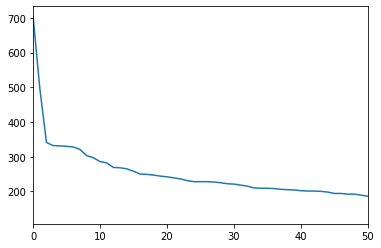

In [36]:
plt.xlim(0,50)
plt.plot(liste)

### Nombre de photos par espèce

<AxesSubplot:xlabel='species', ylabel='Count'>

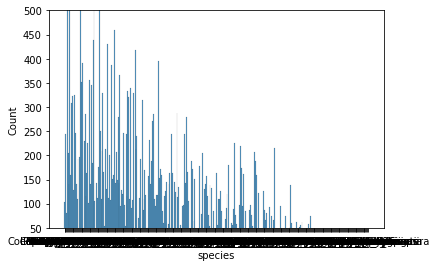

In [37]:
plt.ylim(50,500)
sns.histplot(get_data_minphoto(data_train,3).species)

In [38]:
df_viz = pd.DataFrame(get_data_minphoto(data_train,3).species.value_counts()).reset_index()
df_viz.columns = ['species','nb']
df_viz.sort_values(by='nb')

,species,nb
340,Erebia_palarica,3
332,Hipparchia_syriaca,3
333,Polyommatus_ripartii,3
334,Pamiria_omphisa,3
339,Allancastria_deyrollei,3
...,...,...
4,Melitaea_athalia,519
3,Plebejus_idas,573
2,Polyommatus_icarus,610
1,Pieris_napi,633


In [39]:
df_viz.head(200)

,species,nb
0,Parnassius_apollo,1414
1,Pieris_napi,633
2,Polyommatus_icarus,610
3,Plebejus_idas,573
4,Melitaea_athalia,519
...,...,...
195,Euchloe_crameri,45
196,Argynnis_pandora,45
197,Nymphalis_egea,45
198,Satyrium_pruni,44


### Nombre de photos totales en fonction du nombre de photo par espèce

In [192]:
liste = []
for i in range(1,10,1):
    liste.append(get_data_minphoto(data_train,i).species.nunique()*i)
for i in range(10,205,10):
    liste.append(get_data_minphoto(data_train,i).species.nunique()*i)

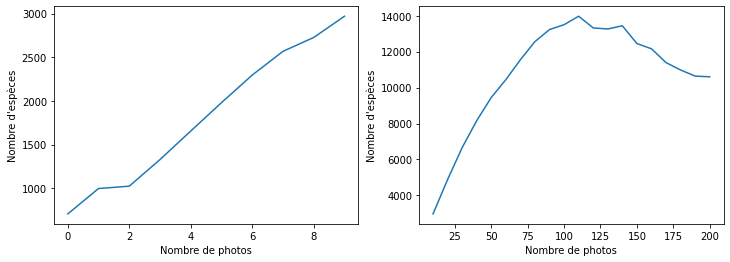

In [205]:
plt.figure(figsize=(12,4))
plt.title("Nombre de photos totales en fonction du nombre de photo par espèce")
plt.subplot(1,2,1)
plt.xlabel('Nombre de photos')
plt.ylabel("Nombre d'espèces")
plt.plot(liste[0:10])
plt.subplot(1,2,2)
plt.xlabel('Nombre de photos')
plt.ylabel("Nombre d'espèces")
plt.plot([i for i in range(10,201,10)], liste[9:]);

In [209]:
# Tableaux du nombre de photos totales selon le nombre de photos par classe 
# pour un dataset balanced (les classes n'ayant pas assez de photos étant écartées)
pd.DataFrame([liste,[i for i in range(1,10,1)]+[i for i in range(10,201,10)]])

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,705,996,1023,1328,1655,1980,2296,2568,2727,2970,...,13970,13320,13260,13440,12450,12160,11390,10980,10640,10600
1,1,2,3,4,5,6,7,8,9,10,...,110,120,130,140,150,160,170,180,190,200


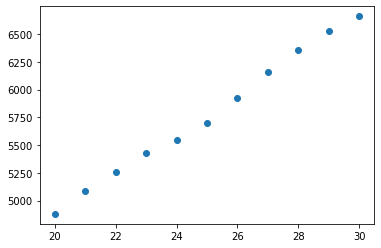

In [216]:
liste2 = []
for i in range(20,31,1):
    liste2.append(get_data_minphoto(data_train,i).species.nunique()*i)
plt.scatter([i for i in range(20,31)], liste2)

## Generator

## Under sampling

### Tri le df val à partir des espèces du train

In [89]:
def filter_val_test(df_train, df_to_filter):
    def filtre(x):
        if x not in espece:
            return False
        else :
            return True
    espece = df_train.species.unique()
    df_to_filter['filter'] = df_to_filter['species'].apply(filtre)
    df_filtered = df_to_filter.loc[df_to_filter['filter'] == True].copy()
    df_filtered.drop('filter', axis = 1, inplace = True)
    return df_filtered

### Prend un sampling des espèces de plus de x photos

In [171]:
def resampling(df):
    count = pd.DataFrame(df['species'].value_counts().reset_index())
    count.columns = ['species', 'nombre']
    minimum = min(count['nombre'])
    begin = True
    for i in count['species']:
        if begin:
            new_df = df.loc[df['species'] == i].sample(minimum)
            begin = False
        elif i not in new_df['species']:
            add_to = df.loc[df['species'] == i].sample(minimum)
            new_df = pd.concat([new_df, add_to],axis = 0)
    # Shuffle the dataset
    new_df.sample(frac=1)
    return new_df

# Trier les espèces en supprimant les pays peu représentés

In [215]:
data_train.country.value_counts()

Switzerland                  26126
France                        1861
Italy                         1632
Germany                       1326
Austria                        856
                             ...  
Biasca                           1
Cavaglia                         1
/ V. Bedretto                    1
Tujetsch GR : Sedrun sura        1
Palestine                        1
Name: country, Length: 86, dtype: int64